In [262]:
#TO RE-RUN
%reset -f

In [313]:
from sklearn import preprocessing
from time import time
import numpy as np
import csv
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline


from sklearn.metrics import pairwise_distances
from IPython.display import display, HTML
from operator import truediv
import pandas as pd
import time
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('classic')

%matplotlib inline

import sys
sys.path.insert(1, "/home/ilmira/healthforecast/readmission/src/")
from TypeFeatImputer import TypeFeatImputer

In [314]:
#df_all=pd.read_csv(os.path.join('resources','diabetic_data_processed_withweight.csv'),';')
#df_all=pd.read_csv(os.path.join('resources','diabetic_data_processed_2017_09_28.csv'),';')
df_all=pd.read_csv(os.path.join('resources','diabetic_data_extended_2017_09_29_14_xrp.csv'),',')

In [315]:
print df_all.shape
print df_all.columns
print len(df_all.patient_nbr.unique())
print df_all.readmitted.value_counts()
print df_all.race.unique()

(101766, 68)
Index([u'Unnamed: 0', u'encounter_id', u'patient_nbr', u'race', u'gender',
       u'age', u'weight', u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital', u'payer_code',
       u'medical_specialty', u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient', u'number_diagnoses', u'max_glu_serum',
       u'A1Cresult', u'metformin', u'repaglinide', u'nateglinide',
       u'chlorpropamide', u'glimepiride', u'acetohexamide', u'glipizide',
       u'glyburide', u'tolbutamide', u'pioglitazone', u'rosiglitazone',
       u'acarbose', u'miglitol', u'troglitazone', u'tolazamide', u'examide',
       u'citoglipton', u'insulin', u'glyburide-metformin',
       u'glipizide-metformin', u'glimepiride-pioglitazone',
       u'metformin-rosiglitazone', u'metformin-pioglitazone', u'Change',
       u'diabetesMed', u'readmitted', u'Diabetis', u'External causes',
       

#### Group rows by patient and get last one

In [316]:
typeEncounter = "first" #["first","last"]

In [317]:
if typeEncounter == "last":
    df=df_all.groupby(['patient_nbr'], sort=True).last()
else:
    df=df_all.groupby(['patient_nbr'], sort=True).first()

df.readmitted.value_counts()
print len(df.encounter_id.unique())

71518


In [318]:
pd.value_counts(df.Diabetis)

0    44770
1    26748
Name: Diabetis, dtype: int64

#### Null values

,%_Null,#_Null,#_No_Null
A1Cresult,0.785,56130,15388
gender,0.000,3,71515
max_glu_serum,0.949,67906,3612
medical_specialty,0.459,32843,38675
payer_code,0.419,29985,41533
race,0.026,1850,69668
weight,0.960,68652,2866


(7, 3)


<function matplotlib.pyplot.show>

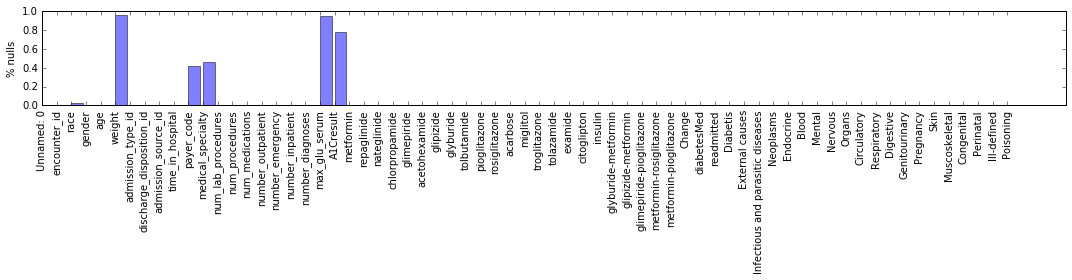

In [319]:
dfNull = np.sum(df.isnull()) / float(df.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df.isnull()),np.sum(df.isnull()==False)], axis=1)
dfNullAll.columns= ["%_Null","#_Null","#_No_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null","#_No_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(15,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:], alpha=0.5)
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Remove highly null features

In [320]:
to_del = []

In [321]:
#to_del = ["A1Cresult","max_glu_serum","weight","medical_specialty"]

In [322]:
#Filter_selected cols
cols = [c for c in df.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = df[cols]
print dfFiltered.shape
print dfFiltered.columns

(71518, 67)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital', u'payer_code',
       u'medical_specialty', u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient', u'number_diagnoses', u'max_glu_serum',
       u'A1Cresult', u'metformin', u'repaglinide', u'nateglinide',
       u'chlorpropamide', u'glimepiride', u'acetohexamide', u'glipizide',
       u'glyburide', u'tolbutamide', u'pioglitazone', u'rosiglitazone',
       u'acarbose', u'miglitol', u'troglitazone', u'tolazamide', u'examide',
       u'citoglipton', u'insulin', u'glyburide-metformin',
       u'glipizide-metformin', u'glimepiride-pioglitazone',
       u'metformin-rosiglitazone', u'metformin-pioglitazone', u'Change',
       u'diabetesMed', u'readmitted', u'Diabetis', u'External causes',
       u'Infectious and 

#### Check Object (text) features 

In [323]:
print df.info().tolist()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 135 to 189502619
Data columns (total 67 columns):
Unnamed: 0                           71518 non-null int64
encounter_id                         71518 non-null int64
race                                 69668 non-null object
gender                               71515 non-null float64
age                                  71518 non-null int64
weight                               2866 non-null object
admission_type_id                    71518 non-null int64
discharge_disposition_id             71518 non-null int64
admission_source_id                  71518 non-null int64
time_in_hospital                     71518 non-null int64
payer_code                           41533 non-null object
medical_specialty                    38675 non-null object
num_lab_procedures                   71518 non-null int64
num_procedures                       71518 non-null int64
num_medications                      71518 non-null int64
number_out

AttributeError: 'NoneType' object has no attribute 'tolist'

In [324]:
for c in dfFiltered.columns:
    if dfFiltered[c].dtype == 'object':
        print c, len(dfFiltered[c].unique()),":"
        print pd.value_counts(dfFiltered[c])
        print 

race 6 :
Caucasian          53556
AfricanAmerican    12916
Hispanic            1514
Other               1170
Asian                512
Name: race, dtype: int64

weight 10 :
[75-100)     1208
[50-75)       796
[100-125)     558
[125-150)     133
[25-50)        88
[0-25)         37
[150-175)      34
[175-200)      10
>200            2
Name: weight, dtype: int64

payer_code 18 :
MC    21332
HM     4157
BC     3442
SP     3217
MD     2267
CP     1918
UN     1888
CM     1430
OG      656
PO      459
DM      384
WC      119
CH      115
OT       65
MP       48
SI       35
FR        1
Name: payer_code, dtype: int64

medical_specialty 71 :
InternalMedicine                        11316
Family/GeneralPractice                   5335
Emergency/Trauma                         4510
Cardiology                               4371
Surgery-General                          2364
Orthopedics                              1174
Orthopedics-Reconstructive               1071
Radiologist                              

#### Convert categorical feature into dummy

In [325]:
df_spec = pd.get_dummies(dfFiltered['medical_specialty'],dummy_na=False, prefix='medSpec')
for c in df_spec.columns:
    print c
    print pd.value_counts(df_spec[c])
    
df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_spec], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

medSpec_AllergyandImmunology
0    71513
1        5
Name: medSpec_AllergyandImmunology, dtype: int64
medSpec_Anesthesiology
0    71507
1       11
Name: medSpec_Anesthesiology, dtype: int64
medSpec_Anesthesiology-Pediatric
0    71501
1       17
Name: medSpec_Anesthesiology-Pediatric, dtype: int64
medSpec_Cardiology
0    67147
1     4371
Name: medSpec_Cardiology, dtype: int64
medSpec_Cardiology-Pediatric
0    71511
1        7
Name: medSpec_Cardiology-Pediatric, dtype: int64
medSpec_DCPTEAM
0    71512
1        6
Name: medSpec_DCPTEAM, dtype: int64
medSpec_Dentistry
0    71515
1        3
Name: medSpec_Dentistry, dtype: int64
medSpec_Emergency/Trauma
0    67008
1     4510
Name: medSpec_Emergency/Trauma, dtype: int64
medSpec_Endocrinology
0    71423
1       95
Name: medSpec_Endocrinology, dtype: int64
medSpec_Endocrinology-Metabolism
0    71511
1        7
Name: medSpec_Endocrinology-Metabolism, dtype: int64
medSpec_Family/GeneralPractice
0    66183
1     5335
Name: medSpec_Family/GeneralPract

In [326]:
dfFiltered["weight"][dfFiltered["weight"] == "[0-25)"] = 0
dfFiltered["weight"][dfFiltered["weight"] == "[25-50)"] = 1
dfFiltered["weight"][dfFiltered["weight"] == "[50-75)"] = 2
dfFiltered["weight"][dfFiltered["weight"] == "[75-100)"] = 3
dfFiltered["weight"][dfFiltered["weight"] == "[100-125)"] = 4
dfFiltered["weight"][dfFiltered["weight"] == "[125-150)"] = 5
dfFiltered["weight"][dfFiltered["weight"] == "[150-175)"] = 6
dfFiltered["weight"][dfFiltered["weight"] == "[175-200)"] = 7
dfFiltered["weight"][dfFiltered["weight"] == ">200"] = 8

print pd.value_counts(dfFiltered.weight)
print dfFiltered.shape
print dfFiltered.columns

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel 

3    1208
2     796
4     558
5     133
1      88
0      37
6      34
7      10
8       2
Name: weight, dtype: int64
(71518, 137)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'medSpec_Surgery-General', u'medSpec_Surgery-Maxillofacial',
       u'medSpec_Surgery-Neuro', u'medSpec_Surgery-Pediatric',
       u'medSpec_Surgery-Plastic', u'medSpec_Surgery-Thoracic',
       u'medSpec_Surgery-Vascular', u'medSpec_SurgicalSpecialty',
       u'medSpec_Urology', u'Poisoning'],
      dtype='object', length=137)


/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [327]:
print dfFiltered['race'].unique()

df_race = pd.get_dummies(dfFiltered['race'],dummy_na=False, prefix='race')
for c in df_race.columns:
    print c
    print pd.value_counts(df_race[c])
    

df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_race], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

['Caucasian' 'AfricanAmerican' 'Hispanic' nan 'Asian' 'Other']
race_AfricanAmerican
0    58602
1    12916
Name: race_AfricanAmerican, dtype: int64
race_Asian
0    71006
1      512
Name: race_Asian, dtype: int64
race_Caucasian
1    53556
0    17962
Name: race_Caucasian, dtype: int64
race_Hispanic
0    70004
1     1514
Name: race_Hispanic, dtype: int64
race_Other
0    70348
1     1170
Name: race_Other, dtype: int64
(71518, 142)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'medSpec_Surgery-Thoracic', u'medSpec_Surgery-Vascular',
       u'medSpec_SurgicalSpecialty', u'medSpec_Urology',
       u'race_AfricanAmerican', u'race_Asian', u'race_Caucasian',
       u'race_Hispanic', u'race_Other', u'Poisoning'],
      dtype='object', length=142)


In [328]:
df_adm = pd.get_dummies(dfFiltered['admission_type_id'],dummy_na=False, prefix='adm')
for c in df_adm.columns:
    print c
    print pd.value_counts(df_adm[c])
    
#Remove non_informative columns
selCols = []
for c in df_adm.columns:
    if c not in ["adm_5", "adm_6","adm_8"]:
        selCols.append(c)
        
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)
print dfFiltered.shape
print dfFiltered.columns

adm_1
1    37191
0    34327
Name: adm_1, dtype: int64
adm_2
0    58486
1    13032
Name: adm_2, dtype: int64
adm_3
0    57695
1    13823
Name: adm_3, dtype: int64
adm_4
0    71509
1        9
Name: adm_4, dtype: int64
adm_5
0    68659
1     2859
Name: adm_5, dtype: int64
adm_6
0    67236
1     4282
Name: adm_6, dtype: int64
adm_7
0    71499
1       19
Name: adm_7, dtype: int64
adm_8
0    71215
1      303
Name: adm_8, dtype: int64
['adm_1', 'adm_2', 'adm_3', 'adm_4', 'adm_7']
(71518, 147)
Index([u'Unnamed: 0', u'encounter_id', u'race', u'gender', u'age', u'weight',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'time_in_hospital',
       ...
       u'race_Asian', u'race_Caucasian', u'race_Hispanic', u'race_Other',
       u'adm_1', u'adm_2', u'adm_3', u'adm_4', u'adm_7', u'Poisoning'],
      dtype='object', length=147)


In [329]:
df_adm = pd.get_dummies(dfFiltered['admission_source_id'],dummy_na=False, prefix='adm_src')

#Remove non_informative columns
selCols = []
for c in df_adm.columns:
    if c not in ["adm_src_9", "adm_src_15","adm_src_17","adm_src_20","adm_src_21"]:
        selCols.append(c)      
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)

for c in dfFiltered.columns:
    if c in df_adm.columns:
        print c, np.unique(dfFiltered[c])
        print pd.value_counts(dfFiltered[c])
    
print dfFiltered.shape
print dfFiltered.columns

['adm_src_1', 'adm_src_2', 'adm_src_3', 'adm_src_4', 'adm_src_5', 'adm_src_6', 'adm_src_7', 'adm_src_8', 'adm_src_10', 'adm_src_11', 'adm_src_13', 'adm_src_14', 'adm_src_22', 'adm_src_25']
adm_src_1 [0 1]
0    50156
1    21362
Name: adm_src_1, dtype: int64
adm_src_2 [0 1]
0    70611
1      907
Name: adm_src_2, dtype: int64
adm_src_3 [0 1]
0    71401
1      117
Name: adm_src_3, dtype: int64
adm_src_4 [0 1]
0    68863
1     2655
Name: adm_src_4, dtype: int64
adm_src_5 [0 1]
0    70873
1      645
Name: adm_src_5, dtype: int64
adm_src_6 [0 1]
0    69695
1     1823
Name: adm_src_6, dtype: int64
adm_src_7 [0 1]
1    38844
0    32674
Name: adm_src_7, dtype: int64
adm_src_8 [0 1]
0    71506
1       12
Name: adm_src_8, dtype: int64
adm_src_10 [0 1]
0    71511
1        7
Name: adm_src_10, dtype: int64
adm_src_11 [0 1]
0    71516
1        2
Name: adm_src_11, dtype: int64
adm_src_13 [0 1]
0    71517
1        1
Name: adm_src_13, dtype: int64
adm_src_14 [0 1]
0    71516
1        2
Name: adm_src_14, 

In [330]:
print np.unique(dfFiltered['discharge_disposition_id'])

df_adm = pd.get_dummies(dfFiltered['discharge_disposition_id'],dummy_na=False, prefix='diss')

#Remove non_informative columns
selCols = []
for c in df_adm.columns:
    if c not in ["diss_26","diss_25","diss_21","diss_20","diss_19","diss_18","diss_11"]:
        selCols.append(c)      
print selCols


df_clean = pd.concat([dfFiltered.iloc[:,:-1], df_adm[selCols]], axis=1)
dfFiltered = pd.concat([df_clean, dfFiltered.iloc[:,-1]], axis=1)

for c in dfFiltered.columns:
    if c in df_adm.columns:
        print c, np.unique(dfFiltered[c])
        print pd.value_counts(dfFiltered[c])
    
print dfFiltered.shape
print dfFiltered.columns

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 27
 28]
['diss_1', 'diss_2', 'diss_3', 'diss_4', 'diss_5', 'diss_6', 'diss_7', 'diss_8', 'diss_9', 'diss_10', 'diss_12', 'diss_13', 'diss_14', 'diss_15', 'diss_16', 'diss_17', 'diss_22', 'diss_23', 'diss_24', 'diss_27', 'diss_28']
diss_1 [0 1]
1    43414
0    28104
Name: diss_1, dtype: int64
diss_2 [0 1]
0    70056
1     1462
Name: diss_2, dtype: int64
diss_3 [0 1]
0    62267
1     9251
Name: diss_3, dtype: int64
diss_4 [0 1]
0    70963
1      555
Name: diss_4, dtype: int64
diss_5 [0 1]
0    70684
1      834
Name: diss_5, dtype: int64
diss_6 [0 1]
0    63049
1     8469
Name: diss_6, dtype: int64
diss_7 [0 1]
0    71106
1      412
Name: diss_7, dtype: int64
diss_8 [0 1]
0    71448
1       70
Name: diss_8, dtype: int64
diss_9 [0 1]
0    71506
1       12
Name: diss_9, dtype: int64
diss_10 [0 1]
0    71512
1        6
Name: diss_10, dtype: int64
diss_12 [0 1]
0    71516
1        2
Name: diss_12, dtype: int64
diss_13 [0

#### Remove rest of categorical features

- Dummified features 

In [331]:
to_del = ["race","admission_type_id","admission_source_id",'discharge_disposition_id','medical_specialty']

#Filter_selected cols
cols = [c for c in dfFiltered.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = dfFiltered[cols]
print dfFiltered.shape
print dfFiltered.columns

(71518, 177)
Index([u'Unnamed: 0', u'encounter_id', u'gender', u'age', u'weight',
       u'time_in_hospital', u'payer_code', u'num_lab_procedures',
       u'num_procedures', u'num_medications',
       ...
       u'diss_14', u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23',
       u'diss_24', u'diss_27', u'diss_28', u'Poisoning'],
      dtype='object', length=177)


- Not useful rows

In [332]:
to_del = [u'Unnamed: 0',"id","encounter_id","payer_code"]

#Filter_selected cols
cols = [c for c in dfFiltered.columns if (c not in to_del) ]#and ('ENF' not in c)
dfFiltered = dfFiltered[cols]
print dfFiltered.shape
print dfFiltered.columns

(71518, 174)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_14', u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23',
       u'diss_24', u'diss_27', u'diss_28', u'Poisoning'],
      dtype='object', length=174)


#### Rename feature: External_causes

In [333]:
print dfFiltered[u"External causes"].values

dfFiltered.insert(dfFiltered.shape[1], "External_causes",dfFiltered["External causes"].values)

dfFiltered = dfFiltered.loc[:,~dfFiltered.columns.isin([u"External causes"])]
print dfFiltered.shape
print dfFiltered.columns

[0 0 1 ..., 0 0 1]
(71518, 174)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23', u'diss_24',
       u'diss_27', u'diss_28', u'Poisoning', u'External_causes'],
      dtype='object', length=174)


#### Reorder class label

In [334]:
print dfFiltered.columns

cols = [c for c in dfFiltered.columns if c != "readmitted"]
cols.append("readmitted")

dfFiltered = dfFiltered[cols]
print dfFiltered.columns
print dfFiltered.shape

Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_15', u'diss_16', u'diss_17', u'diss_22', u'diss_23', u'diss_24',
       u'diss_27', u'diss_28', u'Poisoning', u'External_causes'],
      dtype='object', length=174)
Index([u'gender', u'age', u'weight', u'time_in_hospital',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       ...
       u'diss_16', u'diss_17', u'diss_22', u'diss_23', u'diss_24', u'diss_27',
       u'diss_28', u'Poisoning', u'External_causes', u'readmitted'],
      dtype='object', length=174)
(71518, 174)


#### Find categorical features

In [335]:
#Compute type fields
    
numCols = [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses"
]

catCols = []
reducedCols = cols[:-1]

for i in range(len(cols)):
    if cols[i] not in numCols:
        catCols.append(1)
    else:
        catCols.append(0)
catCols = np.array(catCols)

print "Cat cols:", np.sum(catCols==1)
print "Num cols:", np.sum(catCols==0)
print len(reducedCols)
print len(cols)

Cat cols: 166
Num cols: 8
173
174


#### Identify categorical features with less 5% values

In [336]:
total = 0
minFreq = dfFiltered.shape[0] * 0.005


print "MAX=", dfFiltered.shape[0], "MIN:", minFreq
for c in dfFiltered.columns[catCols == 1]:
    num = np.min(pd.value_counts(dfFiltered[c]))
    if num < minFreq:
        total += 1
        print
        print len(dfFiltered[c].unique()), dfFiltered[c].unique().tolist()
        print pd.value_counts(dfFiltered[c])

print "total low variance features:", total

MAX= 71518 MIN: 357.59

10 [5, 8, 3, 6, 4, 7, 1, 9, 2, 0]
7    18162
6    15908
5    12349
8    11864
4     6756
3     2650
9     2040
2     1111
1      525
0      153
Name: age, dtype: int64

10 [nan, 2, 1, 3, 4, 5, 0, 7, 6, 8]
3    1208
2     796
4     558
5     133
1      88
0      37
6      34
7      10
8       2
Name: weight, dtype: int64

4 [0, 2, 3, 1]
0    70548
2      857
3       78
1       35
Name: repaglinide, dtype: int64

4 [0, 2, 3, 1]
0    71032
2      459
3       18
1        9
Name: nateglinide, dtype: int64

4 [0, 2, 3, 1]
0    71452
2       61
3        4
1        1
Name: chlorpropamide, dtype: int64

4 [0, 2, 1, 3]
0    67833
2     3306
3      242
1      137
Name: glimepiride, dtype: int64

2 [0, 2]
0    71517
2        1
Name: acetohexamide, dtype: int64

4 [0, 2, 3, 1]
0    62711
2     7905
3      552
1      350
Name: glipizide, dtype: int64

2 [0, 2]
0    71499
2       19
Name: tolbutamide, dtype: int64

4 [0, 2, 1, 3]
0    66308
2     4957
3      167
1       86
Nam

#### Data Exploration

Categorical

In [136]:
from sklearn.feature_selection import chi2

catData = []
for rv in dfFiltered.columns[catCols == 1]:

    cleanIc = dfFiltered[rv]

    #Null policy (drop)
    ix = cleanIc.dropna().index
    
    #Get readmitted
    valClass = dfFiltered["readmitted"]>0        
    r, p = chi2(cleanIc.dropna().values.astype(int).reshape(-1,1),valClass[ix].astype(int).reshape(-1,1))    

    catData.append([str(rv),
                    np.sum(cleanIc.isnull() == False),
                    np.sum(cleanIc.isnull() == True),
                    np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                    pd.value_counts(cleanIc).index.astype(int).tolist(), 
                    pd.value_counts(cleanIc).values.tolist(),
                    str(pd.value_counts(dfFiltered[dfFiltered["readmitted"] == 0][rv]).values.tolist()),
                    str((pd.value_counts(dfFiltered[dfFiltered["readmitted"] == 0][rv])/dfFiltered[dfFiltered["readmitted"] == 0][rv].count()).round(3).values.tolist()),
                    str(pd.value_counts(dfFiltered[dfFiltered["readmitted"] > 0][rv]).values.tolist()),
                    str((pd.value_counts(dfFiltered[dfFiltered["readmitted"] > 0][rv])/dfFiltered[dfFiltered["readmitted"] > 0][rv].count()).round(3).values.tolist()),                    
                    round(p,4),
                    "yes" if p<0.05 else "no"
                    ])
    
dfCatData = pd.DataFrame(catData, columns=["variable","num","#nulls",u"%nulls","values","frequencies","non-readmitted (n)","non-readmitted (%)","readmitted (n)","readmitted (%)","p-value","sig."])
print dfCatData[dfCatData["p-value"] < 0.05].shape
display(HTML(dfCatData.to_html(index=False)))

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


(90, 12)


variable,num,#nulls,%nulls,values,frequencies,non-readmitted (n),non-readmitted (%),readmitted (n),readmitted (%),p-value,sig.
gender,71515,71324,0.499,"[1, 0]","[38025, 33490]","[22561, 20421]","[0.525, 0.475]","[15464, 13069]","[0.542, 0.458]",0.002,yes
age,71518,71321,0.499,"[7, 6, 5, 8, 4, 3, 9, 2, 1, 0]","[18210, 15960, 12466, 11589, 6878, 2699, 1900,...","[10254, 9594, 7853, 6521, 4426, 1822, 1254, 76...","[0.239, 0.223, 0.183, 0.152, 0.103, 0.042, 0.0...","[7956, 6366, 5068, 4613, 2452, 877, 646, 360, ...","[0.279, 0.223, 0.178, 0.162, 0.086, 0.031, 0.0...",0.000,yes
weight,2866,139973,0.980,"[3, 2, 4, 5, 1, 0, 6, 7, 8]","[1201, 785, 569, 131, 89, 46, 33, 9, 3]","[479, 372, 248, 61, 44, 16, 9, 4]","[0.388, 0.302, 0.201, 0.049, 0.036, 0.013, 0.0...","[722, 413, 321, 70, 45, 37, 17, 5, 3]","[0.442, 0.253, 0.197, 0.043, 0.028, 0.023, 0.0...",0.976,no
max_glu_serum,3612,139227,0.975,"[0, 1, 2]","[1775, 990, 847]","[1014, 538, 400]","[0.519, 0.276, 0.205]","[761, 452, 447]","[0.458, 0.272, 0.269]",0.000,yes
A1Cresult,15388,127451,0.892,"[2, 0, 1]","[7304, 4600, 3484]","[3854, 2443, 1800]","[0.476, 0.302, 0.222]","[3450, 2157, 1684]","[0.473, 0.296, 0.231]",0.860,no
metformin,71518,71321,0.499,"[0, 2, 3, 1]","[56527, 13718, 838, 435]","[33729, 8462, 530, 264]","[0.785, 0.197, 0.012, 0.006]","[22798, 5256, 308, 171]","[0.799, 0.184, 0.011, 0.006]",0.000,yes
repaglinide,71518,71321,0.499,"[0, 2, 3, 1]","[70592, 824, 73, 29]","[42513, 413, 42, 17]","[0.989, 0.01, 0.001, 0.0]","[28079, 411, 31, 12]","[0.984, 0.014, 0.001, 0.0]",0.000,yes
nateglinide,71518,71321,0.499,"[0, 2, 3, 1]","[71020, 474, 16, 8]","[42700, 269, 11, 5]","[0.993, 0.006, 0.0, 0.0]","[28320, 205, 5, 3]","[0.993, 0.007, 0.0, 0.0]",0.077,no
chlorpropamide,71518,71321,0.499,"[0, 2, 3, 1]","[71446, 67, 4, 1]","[42944, 39, 1, 1]","[0.999, 0.001, 0.0, 0.0]","[28502, 28, 3]","[0.999, 0.001, 0.0]",0.285,no
glimepiride,71518,71321,0.499,"[0, 2, 3, 1]","[67773, 3372, 235, 138]","[40773, 1991, 146, 75]","[0.949, 0.046, 0.003, 0.002]","[27000, 1381, 89, 63]","[0.946, 0.048, 0.003, 0.002]",0.127,no


Numerical

In [137]:
from scipy import stats


numData = dfFiltered[dfFiltered.columns[catCols == 0]].describe().T[["count","mean","std"]].copy()
numData.insert(0,"variable",numData.index.values)
numData.insert(1,"num", numData["count"].isnull().astype(int))
numData.insert(2,"#nulls", dfFiltered.shape[0] - numData["num"])
numData.insert(3,"%nulls", numData["#nulls"] / dfFiltered.shape[0])


numData_non_comp = dfFiltered[dfFiltered["readmitted"] == 0][dfFiltered.columns[catCols == 0]].describe().T[["mean","std"]]
numData_comp = dfFiltered[dfFiltered["readmitted"] > 0][dfFiltered.columns[catCols == 0]].describe().T[["mean","std"]]


numData["mean"] = numData["mean"].round(2).astype(str).str.cat(numData["std"].round(2).astype(str), sep="+/-")
numData["non-readmitted"] = numData_non_comp["mean"].round(3).astype(str).str.cat(numData_non_comp["std"].round(2).astype(str), sep="+/-")
numData["readmitted"] = numData_comp["mean"].round(3).astype(str).str.cat(numData_comp["std"].round(2).astype(str), sep="+/-")

pvals = []
classVal = dfFiltered["readmitted"]>0

for v in numData["variable"].values:
    print v
    pvals.append(stats.mannwhitneyu(dfFiltered[v].values.astype(float).reshape(-1,1), 
                 classVal.astype(int).reshape(-1,1),alternative='two-sided')[1])    

numData["p-value"] = pvals
numData["sig"] = numData["p-value"] < 0.05

numData = numData[["variable","num","#nulls","%nulls","mean","non-readmitted","readmitted","p-value","sig"]]

display(HTML(numData.to_html(index=False)))

time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient


/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


number_emergency
number_inpatient
number_diagnoses


variable,num,#nulls,%nulls,mean,non-readmitted,readmitted,p-value,sig
time_in_hospital,0,142839,1.000,4.29+/-2.95,4.147+/-2.91,4.503+/-2.99,0.000,True
num_lab_procedures,0,142839,1.000,43.08+/-19.95,42.329+/-19.96,44.2+/-19.89,0.000,True
num_procedures,0,142839,1.000,1.43+/-1.76,1.471+/-1.77,1.37+/-1.74,0.000,True
num_medications,0,142839,1.000,15.71+/-8.31,15.474+/-8.57,16.053+/-7.9,0.000,True
number_outpatient,0,142839,1.000,0.28+/-1.07,0.224+/-0.92,0.364+/-1.25,0.000,True
number_emergency,0,142839,1.000,0.1+/-0.51,0.072+/-0.42,0.151+/-0.62,0.000,True
number_inpatient,0,142839,1.000,0.18+/-0.6,0.108+/-0.43,0.283+/-0.79,0.000,True
number_diagnoses,0,142839,1.000,7.25+/-1.99,7.082+/-2.06,7.492+/-1.87,0.000,True


#### Save

In [337]:
print dfFiltered.shape
dfFiltered.to_pickle(os.path.join('resources','clean_data_' + typeEncounter + '.pkl'))

(71518, 174)


#### Normality test

In [219]:
arrNorm = []
for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if catCols[i] == 1 else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

display(HTML(dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]].to_html(index=False)))

(34, 5)
Normal features: 1
Normal numerical features: 0
Normal categorical features: 1
No Normal features: 33
No Normal numerical features: 10
No Normal categorical features: 23


/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/scipy/stats/stats.py:1276: RuntimeWarning: invalid value encountered in absolute
  return SkewtestResult(Z, 2 * distributions.norm.sf(np.abs(Z)))
/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/scipy/stats/stats.py:1355: RuntimeWarning: invalid value encountered in absolute
  return KurtosistestResult(Z, 2 * distributions.norm.sf(np.abs(Z)))


variable,f_val,p_value,norm
admission_source_id,12009.5898,0.0,no
time_in_hospital,11991.3388,0.0,no
num_lab_procedures,885.144,0.0,no
num_procedures,11871.2812,0.0,no
num_medications,20185.104,0.0,no
number_outpatient,110806.9854,0.0,no
number_emergency,162283.3343,0.0,no
number_inpatient,77529.3937,0.0,no
number_diagnoses,5792.8608,0.0,no
metformin,15745.9969,0.0,no


#### Distributions: Numeric features

admission_source_id
Unique values: 17
p-value: 0.0
Normal: False
Mean: 5.65745686401 std: 4.16255115305


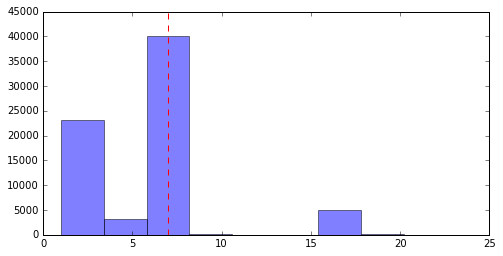

time_in_hospital
Unique values: 14
p-value: 0.0
Normal: False
Mean: 4.28913000923 std: 2.94918931791


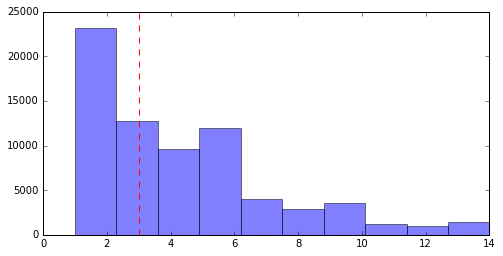

num_lab_procedures
Unique values: 116
p-value: 6.21468844265e-193
Normal: False
Mean: 43.0754775022 std: 19.9521984517


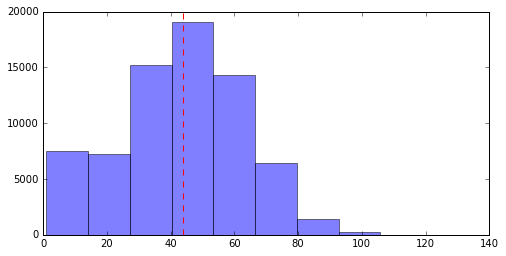

num_procedures
Unique values: 7
p-value: 0.0
Normal: False
Mean: 1.4305769177 std: 1.75985165854


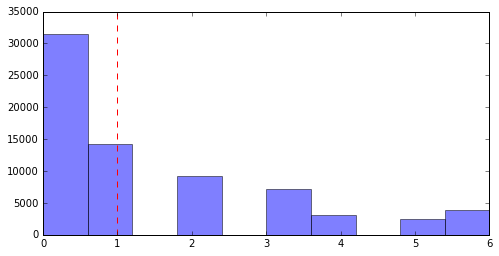

num_medications
Unique values: 75
p-value: 0.0
Normal: False
Mean: 15.7050253083 std: 8.31110460595


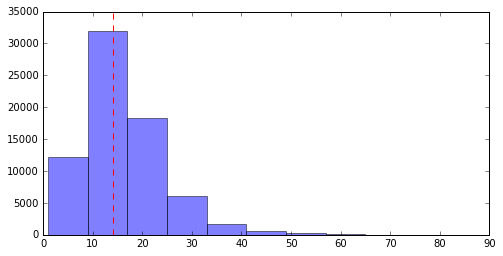

number_outpatient
Unique values: 33
p-value: 0.0
Normal: False
Mean: 0.28006935317 std: 1.06894918085


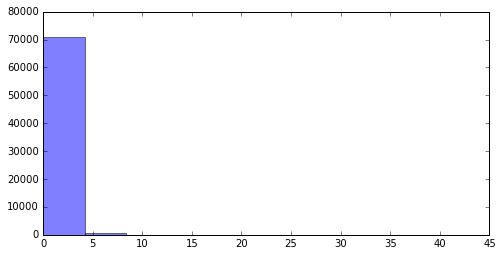

number_emergency
Unique values: 18
p-value: 0.0
Normal: False
Mean: 0.10354036746 std: 0.509183039153


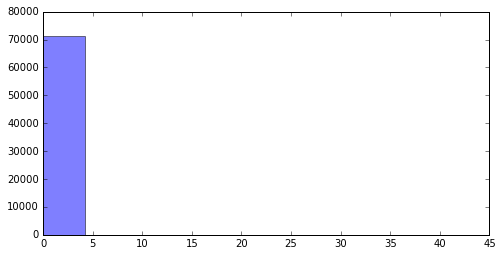

number_inpatient
Unique values: 13
p-value: 0.0
Normal: False
Mean: 0.177829357644 std: 0.603785311366


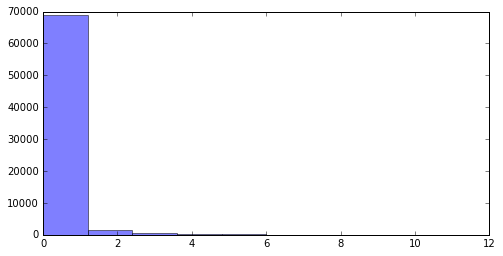

number_diagnoses
Unique values: 16
p-value: 0.0
Normal: False
Mean: 7.24570038312 std: 1.99466048358


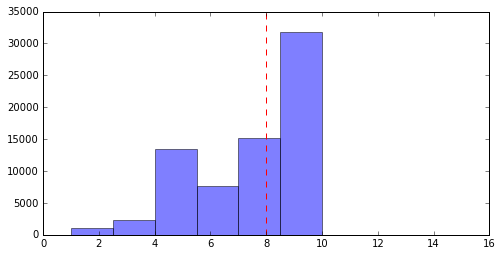

metformin
Unique values: 4
p-value: 0.0
Normal: False
Mean: 0.424858077687 std: 0.835632319895


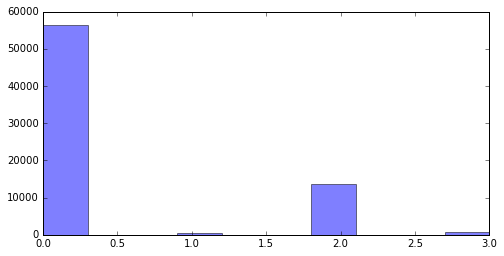

In [220]:
from scipy.stats import boxcox

for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10, alpha=0.5)
        plt.axvline(np.median(cleanIc), c="r", ls="--")
        plt.show()        

gender
(2,)
1.000    38023
0.000    33492
Name: gender, dtype: int64


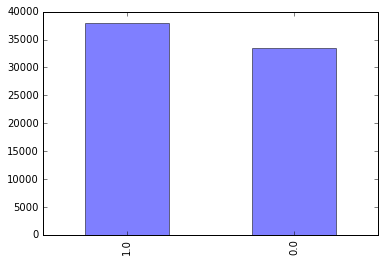

age
(10,)
7    18162
6    15908
5    12349
8    11864
4     6756
3     2650
9     2040
2     1111
1      525
0      153
Name: age, dtype: int64


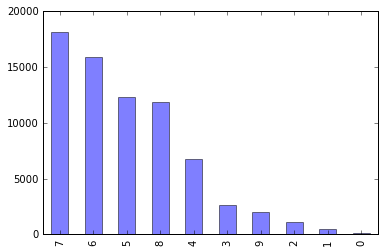

metformin
(4,)
0    56944
2    13347
3      798
1      429
Name: metformin, dtype: int64


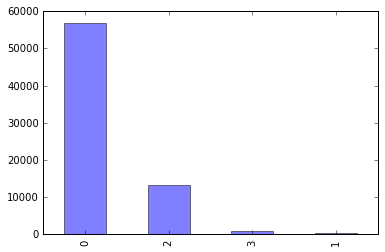

repaglinide
(4,)
0    70548
2      857
3       78
1       35
Name: repaglinide, dtype: int64


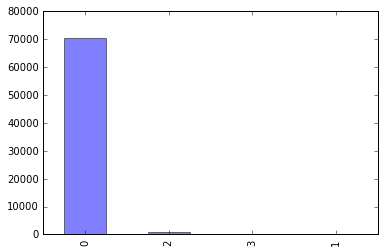

glimepiride
(4,)
0    67833
2     3306
3      242
1      137
Name: glimepiride, dtype: int64


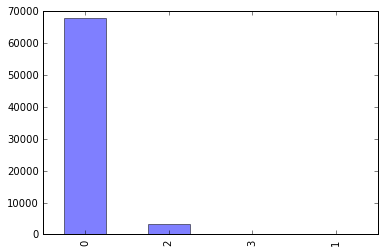

glipizide
(4,)
0    62711
2     7905
3      552
1      350
Name: glipizide, dtype: int64


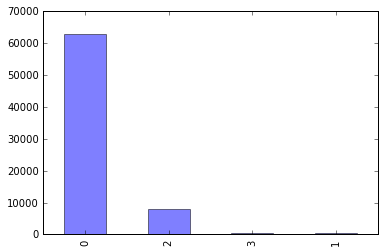

glyburide
(4,)
0    63989
2     6555
3      586
1      388
Name: glyburide, dtype: int64


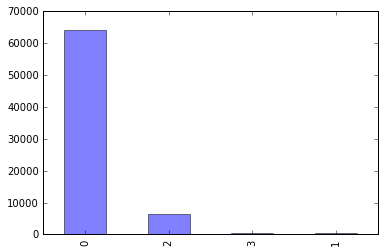

pioglitazone
(4,)
0    66308
2     4957
3      167
1       86
Name: pioglitazone, dtype: int64


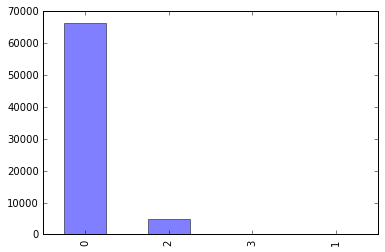

rosiglitazone
(4,)
0    67118
2     4197
3      133
1       70
Name: rosiglitazone, dtype: int64


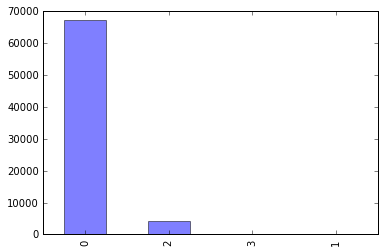

insulin
(4,)
0    34335
2    22247
1     7729
3     7207
Name: insulin, dtype: int64


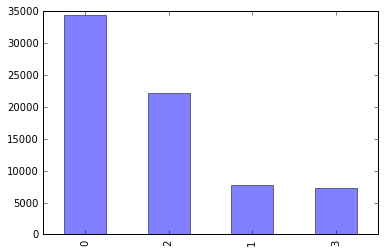

diabetesMed
(2,)
1    54196
0    17322
Name: diabetesMed, dtype: int64


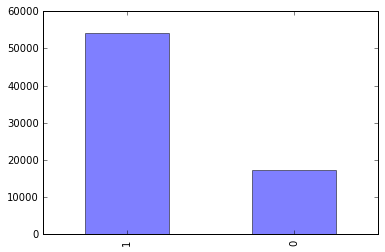

race_AfricanAmerican
(2,)
0    58602
1    12916
Name: race_AfricanAmerican, dtype: int64


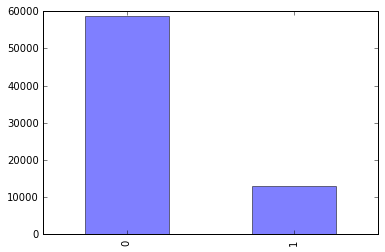

race_Asian
(2,)
0    71006
1      512
Name: race_Asian, dtype: int64


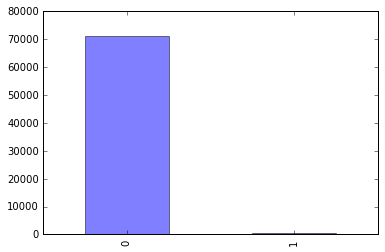

race_Caucasian
(2,)
1    53556
0    17962
Name: race_Caucasian, dtype: int64


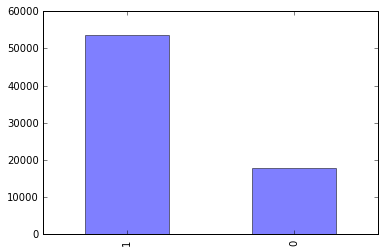

race_Hispanic
(2,)
0    70004
1     1514
Name: race_Hispanic, dtype: int64


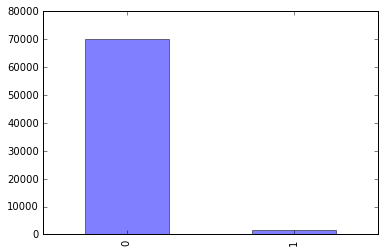

race_Other
(2,)
0    70348
1     1170
Name: race_Other, dtype: int64


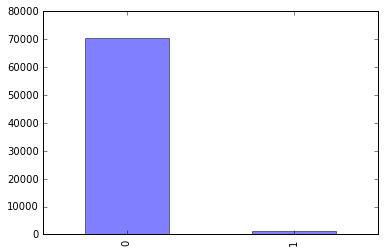

race_nan
(2,)
0    69668
1     1850
Name: race_nan, dtype: int64


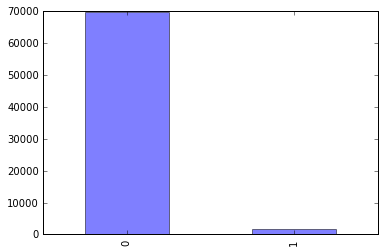

In [195]:
#Categorical
for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":
                
        print rv
        print pd.value_counts(cleanIc).shape
        print pd.value_counts(cleanIc)
        pd.value_counts(cleanIc).plot(kind="bar", alpha=0.5)
        plt.show()